# Loan Prediction
# XGBoost / Hyperparameter tunning

` This notebook is work in progress, I will add comments later`

## Plan
1. Data Analysis 
2. Data Pre processing
3. Models testing
4. Hyperparameter tunning

Let us first start by importing the necessary packages:

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/loan-prediction-based-on-customer-behavior/Test Data.csv
/kaggle/input/loan-prediction-based-on-customer-behavior/Training Data.csv
/kaggle/input/loan-prediction-based-on-customer-behavior/Sample Prediction Dataset.csv


I would be using ggplot theme for my plots

In [2]:
plt.style.use('ggplot')

Import the data

In [3]:
path = '/kaggle/input/loan-prediction-based-on-customer-behavior/Training Data.csv'
pd.set_option('display.max_columns', None)
data = pd.read_csv(path)
data.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


# Data analysis

Before diving into model testing, we have to get familiar with the data and understand what it represents.

In [4]:
data.describe(include='all')

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000,252000,252000,252000,252000,252000,252000.000000,252000.000000,252000.000000
unique,NaN,NaN,NaN,NaN,2,3,2,51,317,29,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,single,rented,no,Physician,Vijayanagaram,Uttar_Pradesh,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,226272,231898,176000,5957,1259,28400,NaN,NaN,NaN
mean,126000.500000,4.997117e+06,49.954071,10.084437,NaN,NaN,NaN,NaN,NaN,NaN,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,NaN,NaN,NaN,NaN,NaN,NaN,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,9.000000,13.000000,0.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


We have multiple categorical data, since we will test various models and not only tree based models, we should econde these variables. <br>
However we can see we do not have any missing values in our data.

## Age

In [6]:
data.groupby('Risk_Flag').describe()['Age']

,count,mean,std,min,25%,50%,75%,max
Risk_Flag,,,,,,,,
0,221004.0,50.093442,17.016058,21.0,35.0,50.0,65.0,79.0
1,30996.0,48.960350,17.368740,21.0,33.0,49.0,64.0,79.0


We can see that the minimum age, maximum age, and even average age does not affect the risk flag variable. <br>
Also we can see that both (0 and 1) have the same difference between the age groups and the mean: standard deviation of 17.

In [7]:
data[data['Risk_Flag'] == 1]['Age'].value_counts(sort=True)[:20]

22    770
66    737
27    720
26    719
33    719
76    666
54    660
24    631
47    616
28    602
21    598
59    591
45    589
30    589
25    584
55    582
48    578
41    570
72    570
29    569
Name: Age, dtype: int64

There is not a big difference between the top 5 of the Risk Flag list, however starting from the sixth position the difference grow, but the distribution of age groups is normal, since we don't have a certain age group repeating. As we can see the first place is for people aged 22, second place for people aged 66.

## Marital status

In [8]:
data.groupby('Risk_Flag')['Married/Single'].value_counts()

Risk_Flag  Married/Single
0          single            197912
           married            23092
1          single             28360
           married             2636
Name: Married/Single, dtype: int64

Here we can see that single people are more risky, 91% of risky flag people are single. But actually this can't tell much since most of people that apply are single.

<AxesSubplot:>

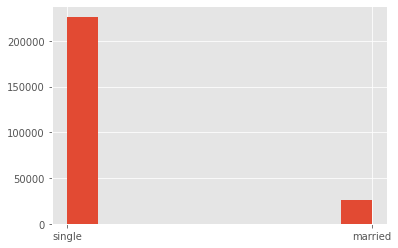

In [9]:
data['Married/Single'].hist()

## Income

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


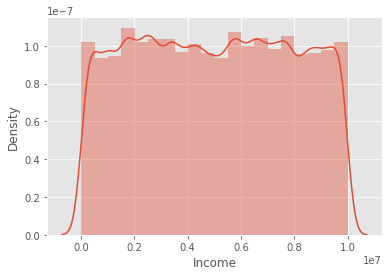

In [10]:
sns.distplot(data['Income'], bins=20)
plt.show()

<AxesSubplot:>

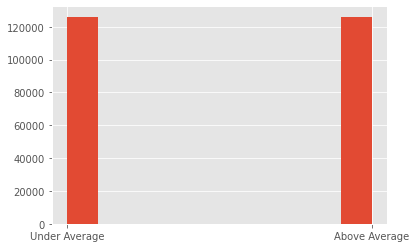

In [11]:
data['Status'] = np.where(data['Income']>=data['Income'].mean(), 'Above Average', 'Under Average')
data['Status'].hist()

The data is distributed equally between people with under average and above average income.

Risk_Flag
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Status, dtype: object

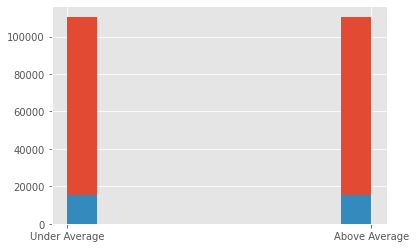

In [12]:
data.groupby('Risk_Flag')['Status'].hist()

The income does not affect the risk flag variable of a person.

In [13]:
data.groupby("Risk_Flag")['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Risk_Flag,,,,,,,,
0,221004.0,5.000449e+06,2.872255e+06,10310.0,2520632.75,5002134.0,7470480.0,9999938.0
1,30996.0,4.973359e+06,2.921065e+06,10675.0,2421029.00,4977653.0,7556052.0,9994501.0


The average salary of Risk Flag group 1 is 0.3 e+06 smaller than the non risky group. Meanwhile other metrics for both groups are similar.

## State

In [14]:
data.groupby("Risk_Flag")['STATE'].value_counts(sort=True)

Risk_Flag  STATE            
0          Uttar_Pradesh        25057
           Maharashtra          22667
           Andhra_Pradesh       22362
           West_Bengal          20474
           Bihar                17197
           Tamil_Nadu           14831
           Madhya_Pradesh       11942
           Karnataka            10666
           Gujarat              10065
           Rajasthan             7882
           Jharkhand             7770
           Haryana               6910
           Telangana             6545
           Assam                 6132
           Delhi                 4916
           Kerala                4835
           Punjab                4295
           Odisha                3994
           Chhattisgarh          3323
           Uttarakhand           1741
           Jammu_and_Kashmir     1497
           Puducherry            1266
           Mizoram                755
           Himachal_Pradesh       722
           Tripura                673
           Manipur   

Uttar Pradesh ranks first in both groups which is normal since Uttar has the most number of applicants, 

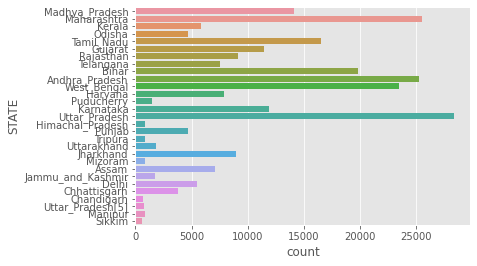

In [15]:
sns.countplot(y='STATE', data=data)
plt.show()

West Bengal ranks second with the most risky flags, even though it is the fourth city in the number of applicants.

In [16]:
data[data['STATE'] == 'West_Bengal'].describe()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,23483.000000,2.348300e+04,23483.000000,23483.000000,23483.000000,23483.000000,23483.000000
mean,125954.237874,5.115302e+06,50.088915,9.916833,6.262658,11.975174,0.128135
std,72783.991484,2.895019e+06,17.002302,5.988934,3.562215,1.408640,0.334247
min,17.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63022.000000,2.570783e+06,35.000000,5.000000,4.000000,11.000000,0.000000
50%,126079.000000,5.134357e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,188979.500000,7.552268e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,251996.000000,9.989145e+06,79.000000,20.000000,14.000000,14.000000,1.000000


In [17]:
data.describe()

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


Income and age of applicants from West Bangali does not differ much from other states.

## Current Job

In [18]:
data.groupby("Risk_Flag")['CURRENT_JOB_YRS'].value_counts(sort=True)

Risk_Flag  CURRENT_JOB_YRS
0          3                  26049
           4                  25132
           5                  22119
           6                  20621
           7                  17580
           8                  16693
           9                  15282
           10                 13888
           11                 11793
           1                   9773
           12                  9489
           0                   9461
           2                   9197
           13                  7828
           14                  6099
1          3                   3411
           4                   3207
           5                   2972
           6                   2870
           7                   2345
           8                   2181
           2                   1890
           10                  1880
           9                   1850
           1                   1802
           11                  1802
           0                   1582
 

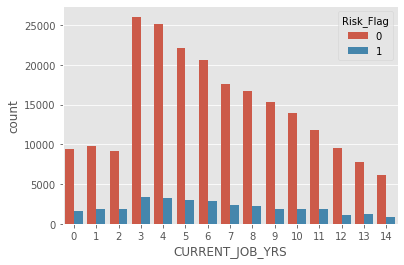

In [19]:
sns.countplot(x='CURRENT_JOB_YRS', hue='Risk_Flag', data=data)
plt.show()

This plot doesn't tell much.

## Profession

In [20]:
data['Profession'].value_counts()

Physician                     5957
Statistician                  5806
Web_designer                  5397
Psychologist                  5390
Computer_hardware_engineer    5372
Drafter                       5359
Magistrate                    5357
Fashion_Designer              5304
Air_traffic_controller        5281
Comedian                      5259
Industrial_Engineer           5250
Mechanical_engineer           5217
Chemical_engineer             5205
Technical_writer              5195
Hotel_Manager                 5178
Financial_Analyst             5167
Graphic_Designer              5166
Flight_attendant              5128
Biomedical_Engineer           5127
Secretary                     5061
Software_Developer            5053
Petroleum_Engineer            5041
Police_officer                5035
Computer_operator             4990
Politician                    4944
Microbiologist                4881
Technician                    4864
Artist                        4861
Lawyer              

Most applicants have well paid jobs.

In [21]:
data.groupby('Profession')['Income'].mean().sort_values(ascending=False)

Profession
Petroleum_Engineer            5.443310e+06
Psychologist                  5.357795e+06
Designer                      5.336802e+06
Scientist                     5.282710e+06
Surgeon                       5.235359e+06
Comedian                      5.199539e+06
Chemical_engineer             5.189805e+06
Mechanical_engineer           5.175032e+06
Artist                        5.164765e+06
Financial_Analyst             5.145753e+06
Consultant                    5.138436e+06
Lawyer                        5.128131e+06
Computer_operator             5.112550e+06
Surveyor                      5.112352e+06
Secretary                     5.102880e+06
Army_officer                  5.094473e+06
Aviator                       5.074104e+06
Fashion_Designer              5.070883e+06
Industrial_Engineer           5.060502e+06
Firefighter                   5.046134e+06
Microbiologist                5.035358e+06
Statistician                  5.028648e+06
Librarian                     5.007590e+06


# Data Encoding:

The data does not need much cleaning, we only need to encode the categorical data so it could be used by our algorithms. For this step I will use LabelEncode of the sklearn pre processing library.

In [22]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data["Married/Single"] = label_encoder.fit_transform(data["Married/Single"])
data["House_Ownership"] = label_encoder.fit_transform(data["House_Ownership"])
data["Car_Ownership"] = label_encoder.fit_transform(data["Car_Ownership"])
data["Profession"] = label_encoder.fit_transform(data["Profession"])
data["CITY"] = label_encoder.fit_transform(data["CITY"])
data["STATE"] = label_encoder.fit_transform(data["STATE"])
data["Status"] = label_encoder.fit_transform(data["Status"])

In [23]:
data['STATE'].value_counts()

25    28400
14    25562
0     25297
28    23483
2     19780
22    16537
13    14122
11    11855
6     11408
20     9174
10     8965
7      7890
23     7524
1      7062
12     5805
5      5490
19     4720
17     4658
4      3834
27     1874
9      1780
18     1433
16      849
15      849
8       833
24      809
26      743
3       656
21      608
Name: STATE, dtype: int64

Tada!

# Testing Classifiers

Moving to the next step, we will start by importing the classifiers that we will test:
* Logistic Regression
* XGBoost
* Random Forest 
* Gradient Boosting

We would test other classifiers but it takes so much time to run a cross validation test on many classifiers.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

And of course evaluation metrics are important, alongside the splitting function.

In [25]:
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score, train_test_split

First, we have to drop the target column from the data.

In [26]:
pred = data['Risk_Flag']
data.drop(columns=['Risk_Flag'], inplace=True)

To avoid wasting too much time running one cell of code, first we will test logistic regression and gradient boosting, and then move to XGBoost and Random Forest.

In [27]:
'''
KFold_Score = pd.DataFrame()
classifiers = ['LogisticRegression', 'GradientBoostingClassifier']
models = [
          LogisticRegression(max_iter = 1000),
          GradientBoostingClassifier(random_state=0)
         ]
'''

"\nKFold_Score = pd.DataFrame()\nclassifiers = ['LogisticRegression', 'GradientBoostingClassifier']\nmodels = [\n          LogisticRegression(max_iter = 1000),\n          GradientBoostingClassifier(random_state=0)\n         ]\n"

In [28]:
'''
j = 0
for i in models:
    model = i
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    KFold_Score[classifiers[j]] = (cross_val_score(model, data, np.ravel(pred), scoring = 'accuracy', cv=cv))
    j = j+1
'''

"\nj = 0\nfor i in models:\n    model = i\n    cv = KFold(n_splits=5, random_state=0, shuffle=True)\n    KFold_Score[classifiers[j]] = (cross_val_score(model, data, np.ravel(pred), scoring = 'accuracy', cv=cv))\n    j = j+1\n"

Well, we can clearly see we have got nearly the same mean cross validation score. Moving on to the next test. `I have commented the code because of the limited computing power.`

In [29]:
'''
mean = pd.DataFrame(KFold_Score.mean(), index= classifiers)
KFold_Score = pd.concat([KFold_Score,mean.T])
KFold_Score.index=['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean']
KFold_Score.T.sort_values(by=['Mean'], ascending = False)
'''

"\nmean = pd.DataFrame(KFold_Score.mean(), index= classifiers)\nKFold_Score = pd.concat([KFold_Score,mean.T])\nKFold_Score.index=['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean']\nKFold_Score.T.sort_values(by=['Mean'], ascending = False)\n"

In [30]:
'''
KFold_Score2 = pd.DataFrame()
classifiers = ['RandomForestClassifier', 'XGBoostClassifier']
models = [
          RandomForestClassifier(n_estimators=200, random_state=0),
          xgb.XGBClassifier(n_estimators=100),
         ]
j = 0
for i in models:
    model = i
    cv = KFold(n_splits=5, random_state=0, shuffle=True)
    KFold_Score2[classifiers[j]] = (cross_val_score(model, data, np.ravel(pred), scoring = 'accuracy', cv=cv))
    j = j+1
'''

"\nKFold_Score2 = pd.DataFrame()\nclassifiers = ['RandomForestClassifier', 'XGBoostClassifier']\nmodels = [\n          RandomForestClassifier(n_estimators=200, random_state=0),\n          xgb.XGBClassifier(n_estimators=100),\n         ]\nj = 0\nfor i in models:\n    model = i\n    cv = KFold(n_splits=5, random_state=0, shuffle=True)\n    KFold_Score2[classifiers[j]] = (cross_val_score(model, data, np.ravel(pred), scoring = 'accuracy', cv=cv))\n    j = j+1\n"

In [31]:
'''
mean = pd.DataFrame(KFold_Score2.mean(), index= classifiers)
KFold_Score2 = pd.concat([KFold_Score2,mean.T])
KFold_Score2.index=['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean']
KFold_Score2.T.sort_values(by=['Mean'], ascending = False)
'''

"\nmean = pd.DataFrame(KFold_Score2.mean(), index= classifiers)\nKFold_Score2 = pd.concat([KFold_Score2,mean.T])\nKFold_Score2.index=['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean']\nKFold_Score2.T.sort_values(by=['Mean'], ascending = False)\n"

After testig four classifiers, we can see that XGBoostClassifier returns the best mean cross validation score.

# Hyperparameter tunning:

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data, pred, test_size=0.2, random_state=42)

Instead of numpy arrays or pandas dataFrame, XGBoost uses DMatrices.

In [33]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

We will start by defining the initial parameters of the model:

In [34]:
params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:linear',
}

Since this is a classification problem, we will set the evaluation metric to log loss

In [35]:
params['eval_metric'] = 'logloss'

Train the model with the parameters selected, and specify early stopping at ten rounds

In [36]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[14:33:01] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-logloss:0.54142
[1]	Test-logloss:0.45873
[2]	Test-logloss:0.41086
[3]	Test-logloss:0.38299
[4]	Test-logloss:0.36444
[5]	Test-logloss:0.35305
[6]	Test-logloss:0.34460
[7]	Test-logloss:0.33937
[8]	Test-logloss:0.33460
[9]	Test-logloss:0.33234
[10]	Test-logloss:0.32901
[11]	Test-logloss:0.32643
[12]	Test-logloss:0.32244
[13]	Test-logloss:0.32125
[14]	Test-logloss:0.32057
[15]	Test-logloss:0.32005
[16]	Test-logloss:0.31842
[17]	Test-logloss:0.31529
[18]	Test-logloss:0.31291
[19]	Test-logloss:0.31105
[20]	Test-logloss:0.31036
[21]	Test-logloss:0.30843
[22]	Test-logloss:0.30717
[23]	Test-logloss:0.30581
[24]	Test-logloss:0.30415
[25]	Test-logloss:0.30305
[26]	Test-logloss:0.30214
[27]	Test-logloss:0.30023
[28]	Test-logloss:0.29870
[29]	Test-logloss:0.29800
[30]	Test-logloss:0.29599
[31]	Test-logloss:0.29418
[32]	Test-logloss:0.29239
[33]	Test-logloss:0.29068
[34]	Te

Let us check the initial log loss

In [37]:
print("Best Log Loss: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best Log Loss: 0.25 with 110 rounds


In [38]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=999,
    seed=42,
    nfold=5,
    metrics={'logloss'},
    early_stopping_rounds=10
)
cv_results

[14:33:19] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:20] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:20] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:20] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:33:20] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.540610,0.000106,0.540881,0.000185
1,0.457465,0.000200,0.458058,0.000436
2,0.408339,0.000355,0.409367,0.000466
3,0.379780,0.000540,0.381161,0.000640
4,0.361996,0.000667,0.363675,0.000493
...,...,...,...,...
147,0.202234,0.001359,0.242111,0.001847
148,0.201976,0.001286,0.242592,0.002140
149,0.201638,0.001396,0.242426,0.002131
150,0.201116,0.001516,0.241786,0.002064


In [39]:
cv_results['test-logloss-mean'].min()

0.241133

We will start by searching two parameters: max_depth and min_child_weight

In [40]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [41]:
min_log = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=999,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10)
    
    mean_log = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\logloss {} for {} rounds".format(mean_log, boost_rounds))
    if mean_log < min_log:
        min_log = mean_log
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, logloss: {}".format(best_params[0], best_params[1], min_log))

CV with max_depth=9, min_child_weight=5
[14:34:56] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:56] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:56] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:57] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:34:57] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
\logloss 0.23889960000000002 for 50 rounds
CV with max_depth=9, min_child_weight=6
[14:35:52] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:53] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:35:53] WARNING: ../src/objective/regress

Save these two parameters to the params dictionary

In [42]:
params['max_depth'] = 9
params['min_child_weight'] = 7

Moving to the subsample and colsample paramters

In [43]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [44]:
min_log = float("Inf")
best_params = None
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=500,
        seed=42,
        nfold=5,
        metrics={'logloss'},
        early_stopping_rounds=10
    )
    mean_log = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\log {} for {} rounds".format(mean_log, boost_rounds))
    if mean_log < min_log:
        min_log = mean_log
        best_params = (subsample,colsample)
print("Best params: {}, {}, log: {}".format(best_params[0], best_params[1], min_log))

CV with subsample=1.0, colsample=1.0
[14:43:06] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:43:06] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:43:07] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:43:07] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:43:07] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
\log 0.23428899999999997 for 59 rounds
CV with subsample=1.0, colsample=0.9
[14:44:11] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:11] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:44:12] WARNING: ../src/objective/regression_obj.cu

The optimal results are 1 and 0.7

In [45]:
params['subsample'] = 1.0
params['colsample_bytree'] = .7

Tuning the learning rate might take some time, if you clone the code prepare to wait up to 30mins for this cell to be executed

In [46]:
min_log = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    params['eta'] = eta
    cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=500,
    seed=42,
    nfold=5,
    metrics=['logloss'],
    early_stopping_rounds=10)
    mean_log = cv_results['test-logloss-mean'].min()
    boost_rounds = cv_results['test-logloss-mean'].argmin()
    print("\Log Loss {} for {} rounds\n".format(mean_log, boost_rounds))
    if mean_log < min_log:
        min_log = mean_log
        best_params = eta
print("Best params: {}, Log Loss: {}".format(best_params, min_log))

CV with eta=0.3
[14:57:19] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:19] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:19] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:19] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:57:20] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
\Log Loss 0.23170520000000003 for 65 rounds

CV with eta=0.2
[14:58:18] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:58:18] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[14:58:18] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated i

The best learning rate is 0.1

In [47]:
params['eta'] = .1

Let us have a look at the parameters we have got so far

In [48]:
params

{'max_depth': 9,
 'min_child_weight': 7,
 'eta': 0.1,
 'subsample': 1.0,
 'colsample_bytree': 0.7,
 'objective': 'reg:linear',
 'eval_metric': 'logloss'}

Train the model

In [49]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=900,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

print("Best Log: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[15:23:28] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-logloss:0.63691
[1]	Test-logloss:0.59047
[2]	Test-logloss:0.55166
[3]	Test-logloss:0.51921
[4]	Test-logloss:0.49198
[5]	Test-logloss:0.46888
[6]	Test-logloss:0.44801
[7]	Test-logloss:0.42949
[8]	Test-logloss:0.41458
[9]	Test-logloss:0.40144
[10]	Test-logloss:0.39030
[11]	Test-logloss:0.38074
[12]	Test-logloss:0.37158
[13]	Test-logloss:0.36364
[14]	Test-logloss:0.35449
[15]	Test-logloss:0.34798
[16]	Test-logloss:0.34269
[17]	Test-logloss:0.33812
[18]	Test-logloss:0.33385
[19]	Test-logloss:0.33014
[20]	Test-logloss:0.32643
[21]	Test-logloss:0.32348
[22]	Test-logloss:0.32028
[23]	Test-logloss:0.31739
[24]	Test-logloss:0.31410
[25]	Test-logloss:0.31143
[26]	Test-logloss:0.30854
[27]	Test-logloss:0.30630
[28]	Test-logloss:0.30361
[29]	Test-logloss:0.30202
[30]	Test-logloss:0.30059
[31]	Test-logloss:0.29942
[32]	Test-logloss:0.29737
[33]	Test-logloss:0.29646
[34]	Te

In [50]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[15:24:17] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-logloss:0.63691
[1]	Test-logloss:0.59047
[2]	Test-logloss:0.55166
[3]	Test-logloss:0.51921
[4]	Test-logloss:0.49198
[5]	Test-logloss:0.46888
[6]	Test-logloss:0.44801
[7]	Test-logloss:0.42949
[8]	Test-logloss:0.41458
[9]	Test-logloss:0.40144
[10]	Test-logloss:0.39030
[11]	Test-logloss:0.38074
[12]	Test-logloss:0.37158
[13]	Test-logloss:0.36364
[14]	Test-logloss:0.35449
[15]	Test-logloss:0.34798
[16]	Test-logloss:0.34269
[17]	Test-logloss:0.33812
[18]	Test-logloss:0.33385
[19]	Test-logloss:0.33014
[20]	Test-logloss:0.32643
[21]	Test-logloss:0.32348
[22]	Test-logloss:0.32028
[23]	Test-logloss:0.31739
[24]	Test-logloss:0.31410
[25]	Test-logloss:0.31143
[26]	Test-logloss:0.30854
[27]	Test-logloss:0.30630
[28]	Test-logloss:0.30361
[29]	Test-logloss:0.30202
[30]	Test-logloss:0.30059
[31]	Test-logloss:0.29942
[32]	Test-logloss:0.29737
[33]	Test-logloss:0.29646
[34]	Te

In [51]:
predictions = best_model.predict(dtest)

# ROC_AUC score on the test set

As required, we will calculate the roc auc score of the model on the test set

In [52]:
metrics.roc_auc_score(y_test, predictions)

0.9480011698265051

We have got quite interesting result, 0.94. Of course it could be improved but we will it here for the moment.
Save the model:

In [53]:
best_model.save_model("my_model.model")

# REFERENCES

For more details of the hyperparameter tuning techniques I have used in this notebook, refer to the following blog, it explains hyperparameter tuning in xgboost in detail:

XGBoost Hyperparameter tunning: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f